In [1]:
%matplotlib inline
# ^^ ensures plots are displayed in the notebook
import matplotlib.pyplot as plt
import numpy as np
import random
import math
import sys
from itertools import repeat

In [2]:
def display(grid):
    cmap = plt.cm.colors.ListedColormap(['white', 'red', 'blue'])
    plt.imshow(grid, cmap=cmap, interpolation='nearest')
    # offset grid lines by half
    plt.xticks(np.arange(-0.5, len(grid[0]), 1), [])
    plt.yticks(np.arange(-0.5, len(grid), 1), [])
    # show grid lines
    plt.grid(True, which='both', color='black', linestyle='-', linewidth=1)
    plt.show()

# this function displays the colours wrong when only player 1 has moved. it displays 0 as white and 1 as red.
# any other time it works as expected.
# i'm guessing this is because of how ListedColormap works
# i'm just gonna say this is fine because this function doesn't *really* matter, and any other solution I can find
# seems way more complicated

In [3]:
def potential_pos_lists(pos):
    x, y = pos
    def filter(iterable):
        return in_range(7, 6, iterable)
        
    row = filter(zip(range(x-3, x+4), repeat(y)))
    col = filter(zip(repeat(x), range(y-3, y+4)))
    diag1 = filter(zip(range(x-3, x+4), range(y-3, y+4)))
    diag2 = filter(zip(range(x-3, x+4), range(y+3, y-4, -1)))

    return [ s for s in [row, col, diag1, diag2] if len(s) >= 4 ]

In [4]:
def potential_val_lists(game, pos):
    return list(map(
        lambda lst: list(map(
            lambda pos: game.state[pos[1]][pos[0]],
            lst)),
        potential_pos_lists(pos)))

In [5]:
def has_win(line, player):
    count = 0
    for val in cell_vals:
        if val == player:
            count += 1
            if count == 4:
                return True
        else:
            count = 0
    return False

In [6]:
def in_range(xthresh, ythresh, tuples):
    return [ (x, y) for (x, y) in tuples if x >= 0 and x < xthresh and y >= 0 and y < ythresh ]

In [7]:
def has_run(cell_vals, player):
    count = 0
    for val in cell_vals:
        if val == player:
            count += 1
        else:
            count = 0
        if count == 4:
            return True
    return False

In [13]:
# def invert_1_2(x):
#     return x ^ 3
    
#vinvert_1_2 = np.vectorize(invert_1_2)

def empty_board():
    return np.zeros((6, 7), dtype=np.int32)

class Connect4:
    def __init__(self, state=None):
        self.state = empty_board() if state is None else state
        self.player = 1
        self.winner = None # None -> game in progress. winner == None && player == None -> draw. maybe change this so -1 -> draw.

    def __repr__(self):
        return f'Connect4 game:\n{self.state}\n' + (
            f'player: {self.player}' if self.player else
            f'winner: {self.winner}' if self.winner else
            'Draw'
        )

    @property
    def opponent(self):
        return self.player ^ 3
    
    def update_player(self):
        self.player = self.opponent

    def play(self, col):
        #print((self, self._open_indices, col))
        def try_play(row):
            if row == -1:
                return None # False
            elif self.state[row][col] == 0:
                self.state[row][col] = self.player
                # check for win here
                # check if we have a run of 4 adjacent (in state range and same value as self.player) values
                self._update_winner(col, row)
                if (self.player):
                    self.update_player()
                return self # True
            else:
                return try_play(row - 1)

        return try_play(self.last_row())

    # def invert(self):
    #     self.state = vinvert_1_2(self.state)

    def last_row(self):
        return self.state.shape[0] - 1

    def _update_winner(self, x, y):
        if True in map(
            lambda line: has_run(line, self.player),
            potential_val_lists(self, (x, y))):
            self.winner = self.player
            self.player = None
        if self._open_indices == []:
            self.player = None # Draw
    
    def random_finish(self):
        while self.player:
            move = random.randint(0, len(self._open_indices)-1)
            self.play(self._open_indices[move])

    @property
    def _open_indices(self):
        return [j for i, j in zip(self.state[0], range(len(self.state[0]))) if i == 0]

    def copy(self):
        tmp = Connect4(state=self.state.copy())
        tmp.player = self.player
        return tmp        

In [9]:
br = '\n'
comma = ','
root2 = math.sqrt(2)

class MCTSnode():
    def __init__(self, game, player=None, move=None):
        self.total = 0
        self.visits = 0
        self.C = root2
        self.game = game
        self.player = player if player else game.opponent
        self.move = move
        self.children = None

    def __repr__(self):
        return f'\n{str(self.game.state).replace(br, comma)}, {self.player=}, {self.move=}, {self.total=}, {self.visits=}, {self.normalized_val=}, {self.children=}'

    @property
    def normalized_val(self):
        return self.total / self.visits

    @property
    def opponent(self):
        return self.player ^ 3 # is it a problem that we have an identical function
        # here and in the game class?
    
    def _print_direct_children(self):
        for child in self.children:
            print((child.game.state, child.total, child.visits, child.normalized_val))

    def UCB1(self, parent_visits):
        if self.visits == 0:
            return sys.float_info.max
        else:
            return (self.total / self.visits) + self.C * math.sqrt(math.log(parent_visits) / self.visits)

    # Score function for given game
    def score(self, game):
        assert game.player == None, "Cannot score incomplete game."
        if game.winner == self.player:
            return 1
        elif game.winner == None: # draw
            return 0
        else:
            return -1

    def simulate(self):
        simulation = self.game.copy()
        if simulation.winner == None:
            simulation.random_finish()
        return self.score(simulation)
        # maybe "random finish" should be in an MCTS subclass or in a wrapper
        # class on the game class ?
        # if we assume it should be in a wrapper class on game class,
        # nothing actually has to change from the perspective of MCTSnode...

    def rollout(self):
        score = self.simulate()
        self.total += score
        self.visits += 1
        return score
        # "rollout" of a terminal node just returns the winner.

    def add_children(self):
        assert self.game._open_indices
        assert self.game.winner == None
        
        self.children = [
            MCTSnode(self.game.copy().play(move), player=self.opponent, move=move) for move in self.game._open_indices
        ]

    def iterate_best_child(self):
        UCBs = [ (child.UCB1(self.visits), i) for (i, child) in list(enumerate(self.children)) ]
        (max_ucb, i) = max(UCBs)
        score = -self.children[i].iteration() # negative score because we're scoring opponent's move
        self.total += score
        self.visits += 1
        return score

    def iteration(self):
        if self.game.player is None:
            score = self.score(self.game)
            self.total += score
            self.visits += 1
            return score
            
        if self.visits == 0 or self.children == []: # unvisited OR guaranteed losing node -- no children
            return self.rollout()
        if self.children is None:
            self.add_children()
            return self.iteration() # can't call iterate_best_child() directly since we don't know if add_children added anything
        else: # have children
            return self.iterate_best_child()

    def iterate(self, n=1):
        for i in range(n):
            self.iteration()
        return self

    def best_move(self):
        if self.children == None:
            return None

        best_child = self.children[0]
        best_val = best_child.normalized_val
        for child in self.children[1:]:
            child_val = child.normalized_val
            if child_val > best_val:
                best_child = child
                best_val = child_val
    
        # for i in range(3):
        #     for j in range(3):
        #         if self.game.state[i][j] == 0 and best_child.game.state[i][j] == self.player:
        #             return (j, i) # if we store move this could be self.move

        if best_child.move is not None:
            return best_child.move
        
        print("ERROR")
        print(self.game)
        print(self.game._open_indices)
        assert False, "Didn't find any move in best_move"




In [10]:
def has_run(cell_vals, player):
    count = 0
    for val in cell_vals:
        if val == player:
            count += 1
        else:
            count = 0
        if count == 4:
            return True
    return False

In [11]:
def AIgame(player=1, iterations=1000):
    assert player == 1 or player == 2, "Player can only be 1 or 2"

    g = Connect4()
    moves = []
    
    while g.player:
        #print(g)
        display(g.state)
        print(f'{moves=}', flush=True)
        if g.player == player:
            x = None
            while x == None:
                _x = input("Input column:")
                try:
                    x = int(_x)
                    res = g.play(x)
                    if res == None: # invalid move -- full row
                        x = None
                        print(f"Invalid. Row {x} is full. Please pick a row that is not full.")
                    else:
                        moves += [x]
                except ValueError:
                    "Invalid input"
            
        else:
            MCTS = MCTSnode(g.copy())
            MCTS.iterate(iterations)

            MCTS._print_direct_children()
            col = MCTS.best_move()
            g.play(col)
            moves += [col]

    #print(g)
    display(g.state)
    print(f'{moves=}')



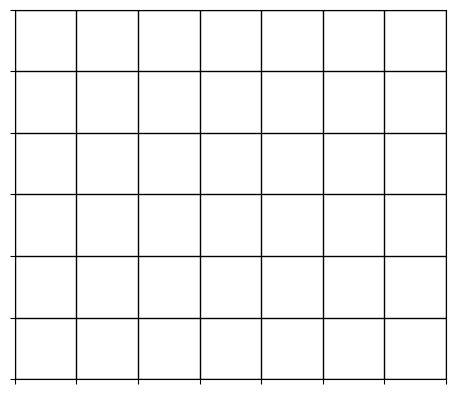

moves=[]


Input column: 3


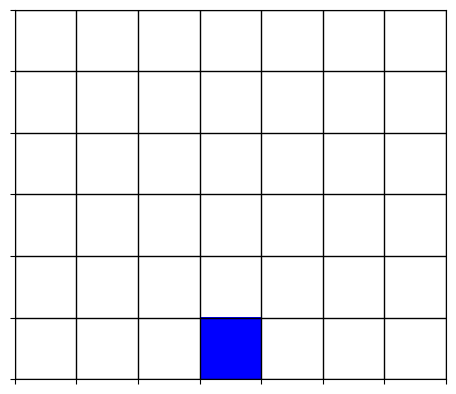

moves=[3]
(array([[0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [2, 0, 0, 1, 0, 0, 0]], dtype=int32), -21, 33, -0.6363636363636364)
(array([[0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 2, 0, 1, 0, 0, 0]], dtype=int32), -48, 180, -0.26666666666666666)
(array([[0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 2, 1, 0, 0, 0]], dtype=int32), -34, 88, -0.38636363636363635)
(array([[0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 2, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0]], dtype=int32), -57, 300, -0.19)
(array([[0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
     

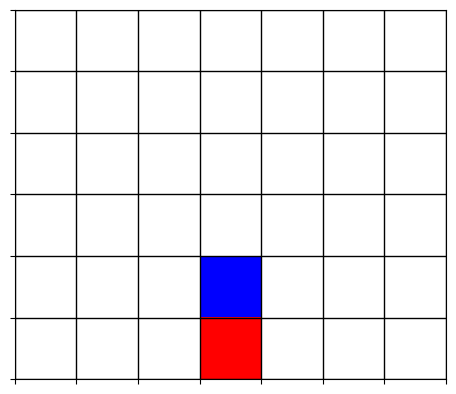

moves=[3, 3]


Input column: 3


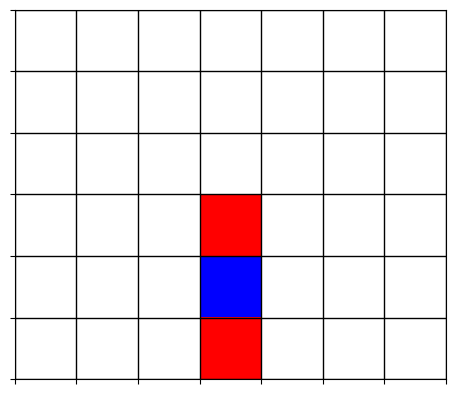

moves=[3, 3, 3]
(array([[0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 2, 0, 0, 0],
       [2, 0, 0, 1, 0, 0, 0]], dtype=int32), -26, 80, -0.325)
(array([[0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 2, 0, 0, 0],
       [0, 2, 0, 1, 0, 0, 0]], dtype=int32), -33, 342, -0.09649122807017543)
(array([[0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 2, 0, 0, 0],
       [0, 0, 2, 1, 0, 0, 0]], dtype=int32), -21, 47, -0.44680851063829785)
(array([[0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 2, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 2, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0]], dtype=int32), -35, 319, -0.109717868338558)
(array([[0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],

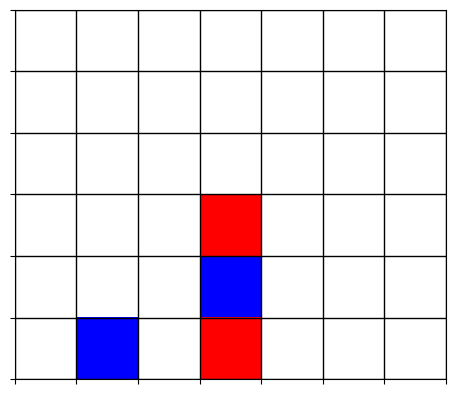

moves=[3, 3, 3, 1]


Input column: 5


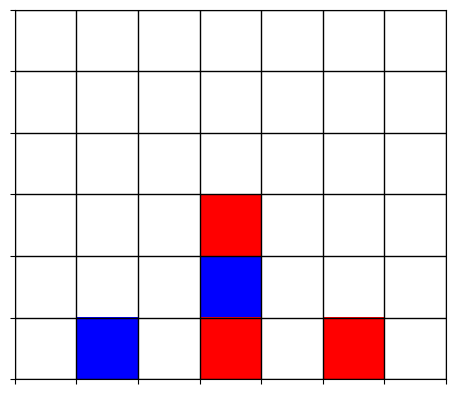

moves=[3, 3, 3, 1, 5]
(array([[0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 2, 0, 0, 0],
       [2, 2, 0, 1, 0, 1, 0]], dtype=int32), -14, 22, -0.6363636363636364)
(array([[0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 2, 0, 2, 0, 0, 0],
       [0, 2, 0, 1, 0, 1, 0]], dtype=int32), -18, 46, -0.391304347826087)
(array([[0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 2, 0, 0, 0],
       [0, 2, 2, 1, 0, 1, 0]], dtype=int32), -15, 27, -0.5555555555555556)
(array([[0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 2, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 2, 0, 0, 0],
       [0, 2, 0, 1, 0, 1, 0]], dtype=int32), -19, 56, -0.3392857142857143)
(array([[0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 

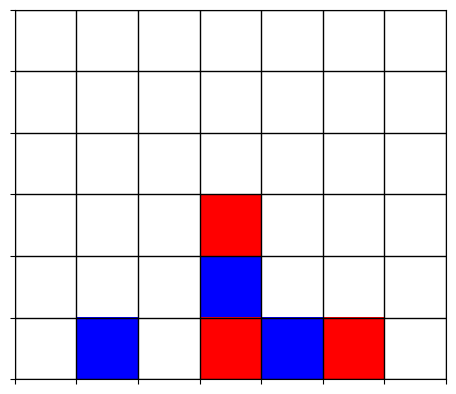

moves=[3, 3, 3, 1, 5, 4]


Input column: 4


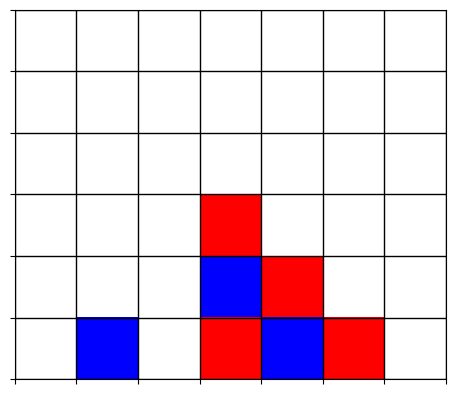

moves=[3, 3, 3, 1, 5, 4, 4]
(array([[0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 2, 1, 0, 0],
       [2, 2, 0, 1, 2, 1, 0]], dtype=int32), -16, 32, -0.5)
(array([[0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 2, 0, 2, 1, 0, 0],
       [0, 2, 0, 1, 2, 1, 0]], dtype=int32), -2, 313, -0.006389776357827476)
(array([[0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 2, 1, 0, 0],
       [0, 2, 2, 1, 2, 1, 0]], dtype=int32), -18, 50, -0.36)
(array([[0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 2, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 2, 1, 0, 0],
       [0, 2, 0, 1, 2, 1, 0]], dtype=int32), -20, 181, -0.11049723756906077)
(array([[0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
  

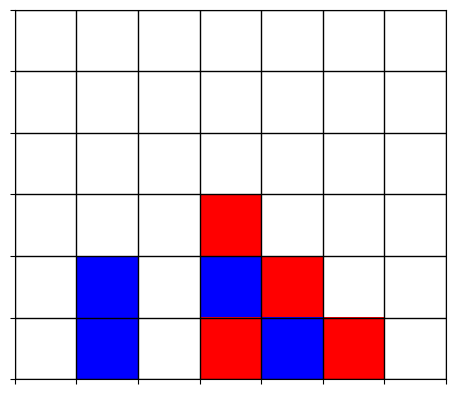

moves=[3, 3, 3, 1, 5, 4, 4, 1]


Input column: 4


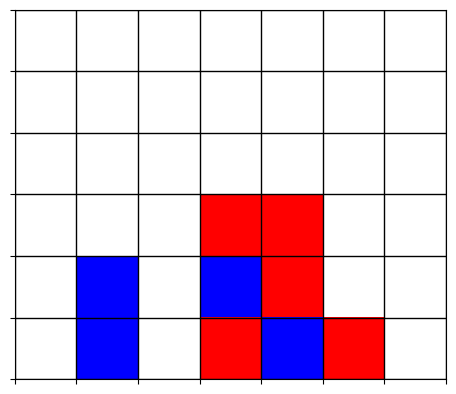

moves=[3, 3, 3, 1, 5, 4, 4, 1, 4]
(array([[0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 0, 0],
       [0, 2, 0, 2, 1, 0, 0],
       [2, 2, 0, 1, 2, 1, 0]], dtype=int32), -18, 63, -0.2857142857142857)
(array([[0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 2, 0, 1, 1, 0, 0],
       [0, 2, 0, 2, 1, 0, 0],
       [0, 2, 0, 1, 2, 1, 0]], dtype=int32), -9, 271, -0.033210332103321034)
(array([[0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 0, 0],
       [0, 2, 0, 2, 1, 0, 0],
       [0, 2, 2, 1, 2, 1, 0]], dtype=int32), -18, 62, -0.2903225806451613)
(array([[0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 2, 0, 0, 0],
       [0, 0, 0, 1, 1, 0, 0],
       [0, 2, 0, 2, 1, 0, 0],
       [0, 2, 0, 1, 2, 1, 0]], dtype=int32), -11, 249, -0.04417670682730924)
(array([[0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0

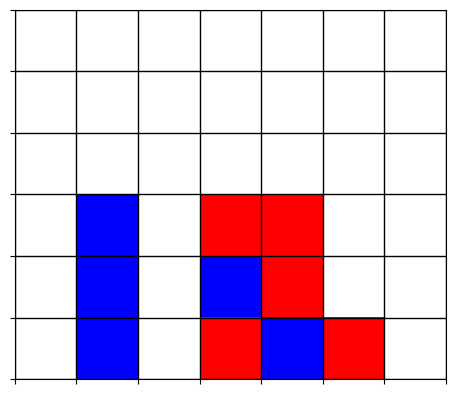

moves=[3, 3, 3, 1, 5, 4, 4, 1, 4, 1]


Input column: 1


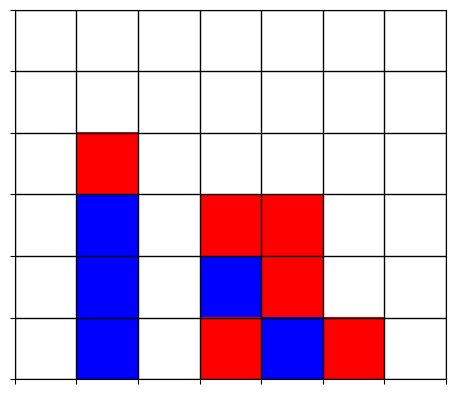

moves=[3, 3, 3, 1, 5, 4, 4, 1, 4, 1, 1]
(array([[0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 2, 0, 1, 1, 0, 0],
       [0, 2, 0, 2, 1, 0, 0],
       [2, 2, 0, 1, 2, 1, 0]], dtype=int32), -33, 95, -0.3473684210526316)
(array([[0, 0, 0, 0, 0, 0, 0],
       [0, 2, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 2, 0, 1, 1, 0, 0],
       [0, 2, 0, 2, 1, 0, 0],
       [0, 2, 0, 1, 2, 1, 0]], dtype=int32), -26, 56, -0.4642857142857143)
(array([[0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 2, 0, 1, 1, 0, 0],
       [0, 2, 0, 2, 1, 0, 0],
       [0, 2, 2, 1, 2, 1, 0]], dtype=int32), -23, 44, -0.5227272727272727)
(array([[0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 2, 0, 0, 0],
       [0, 2, 0, 1, 1, 0, 0],
       [0, 2, 0, 2, 1, 0, 0],
       [0, 2, 0, 1, 2, 1, 0]], dtype=int32), -56, 519, -0.10789980732177264)
(array([[0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 

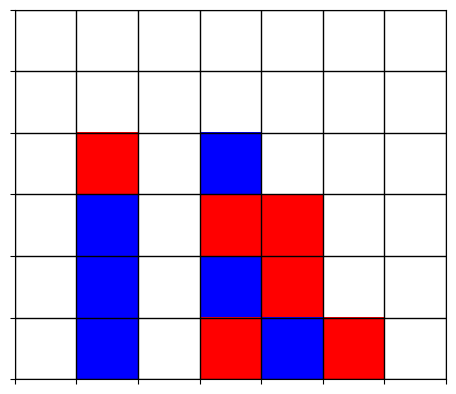

moves=[3, 3, 3, 1, 5, 4, 4, 1, 4, 1, 1, 3]


Input column: 4


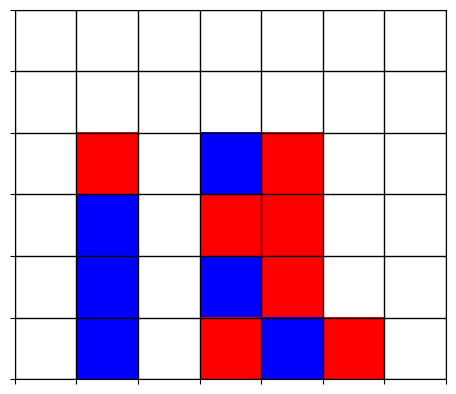

moves=[3, 3, 3, 1, 5, 4, 4, 1, 4, 1, 1, 3, 4]
(array([[0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 2, 1, 0, 0],
       [0, 2, 0, 1, 1, 0, 0],
       [0, 2, 0, 2, 1, 0, 0],
       [2, 2, 0, 1, 2, 1, 0]], dtype=int32), -14, 26, -0.5384615384615384)
(array([[0, 0, 0, 0, 0, 0, 0],
       [0, 2, 0, 0, 0, 0, 0],
       [0, 1, 0, 2, 1, 0, 0],
       [0, 2, 0, 1, 1, 0, 0],
       [0, 2, 0, 2, 1, 0, 0],
       [0, 2, 0, 1, 2, 1, 0]], dtype=int32), -15, 31, -0.4838709677419355)
(array([[0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 2, 1, 0, 0],
       [0, 2, 0, 1, 1, 0, 0],
       [0, 2, 0, 2, 1, 0, 0],
       [0, 2, 2, 1, 2, 1, 0]], dtype=int32), -14, 26, -0.5384615384615384)
(array([[0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 2, 0, 0, 0],
       [0, 1, 0, 2, 1, 0, 0],
       [0, 2, 0, 1, 1, 0, 0],
       [0, 2, 0, 2, 1, 0, 0],
       [0, 2, 0, 1, 2, 1, 0]], dtype=int32), -11, 13, -0.8461538461538461)
(array([[0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0,

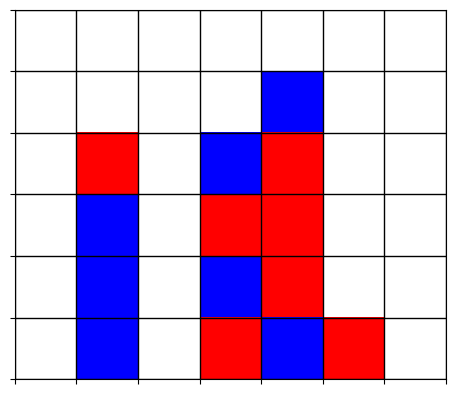

moves=[3, 3, 3, 1, 5, 4, 4, 1, 4, 1, 1, 3, 4, 4]


Input column: 3


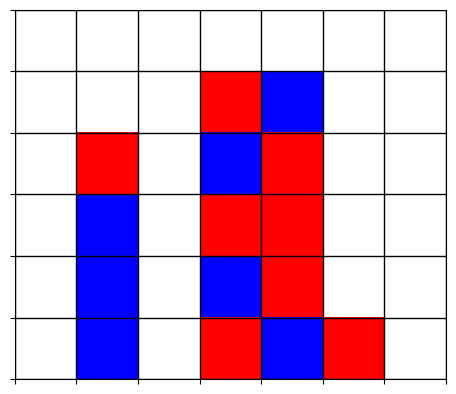

moves=[3, 3, 3, 1, 5, 4, 4, 1, 4, 1, 1, 3, 4, 4, 3]
(array([[0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 2, 0, 0],
       [0, 1, 0, 2, 1, 0, 0],
       [0, 2, 0, 1, 1, 0, 0],
       [0, 2, 0, 2, 1, 0, 0],
       [2, 2, 0, 1, 2, 1, 0]], dtype=int32), -13, 33, -0.3939393939393939)
(array([[0, 0, 0, 0, 0, 0, 0],
       [0, 2, 0, 1, 2, 0, 0],
       [0, 1, 0, 2, 1, 0, 0],
       [0, 2, 0, 1, 1, 0, 0],
       [0, 2, 0, 2, 1, 0, 0],
       [0, 2, 0, 1, 2, 1, 0]], dtype=int32), 8, 259, 0.03088803088803089)
(array([[0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 2, 0, 0],
       [0, 1, 0, 2, 1, 0, 0],
       [0, 2, 0, 1, 1, 0, 0],
       [0, 2, 0, 2, 1, 0, 0],
       [0, 2, 2, 1, 2, 1, 0]], dtype=int32), 22, 347, 0.06340057636887608)
(array([[0, 0, 0, 2, 0, 0, 0],
       [0, 0, 0, 1, 2, 0, 0],
       [0, 1, 0, 2, 1, 0, 0],
       [0, 2, 0, 1, 1, 0, 0],
       [0, 2, 0, 2, 1, 0, 0],
       [0, 2, 0, 1, 2, 1, 0]], dtype=int32), 4, 226, 0.017699115044247787)
(array([[0, 0, 0, 0, 2, 0, 0],
       [0, 0, 

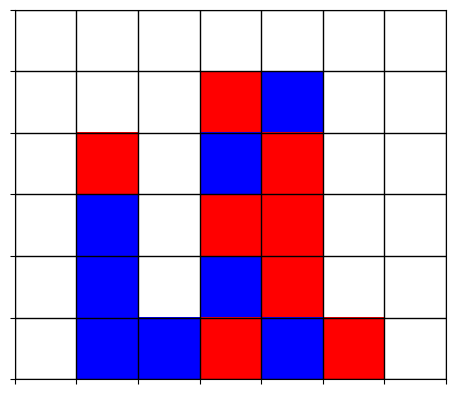

moves=[3, 3, 3, 1, 5, 4, 4, 1, 4, 1, 1, 3, 4, 4, 3, 2]


Input column: 1


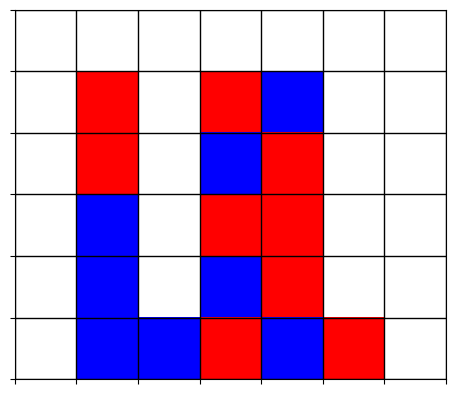

moves=[3, 3, 3, 1, 5, 4, 4, 1, 4, 1, 1, 3, 4, 4, 3, 2, 1]
(array([[0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 1, 2, 0, 0],
       [0, 1, 0, 2, 1, 0, 0],
       [0, 2, 0, 1, 1, 0, 0],
       [0, 2, 0, 2, 1, 0, 0],
       [2, 2, 2, 1, 2, 1, 0]], dtype=int32), -10, 43, -0.23255813953488372)
(array([[0, 2, 0, 0, 0, 0, 0],
       [0, 1, 0, 1, 2, 0, 0],
       [0, 1, 0, 2, 1, 0, 0],
       [0, 2, 0, 1, 1, 0, 0],
       [0, 2, 0, 2, 1, 0, 0],
       [0, 2, 2, 1, 2, 1, 0]], dtype=int32), 17, 195, 0.08717948717948718)
(array([[0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 1, 2, 0, 0],
       [0, 1, 0, 2, 1, 0, 0],
       [0, 2, 0, 1, 1, 0, 0],
       [0, 2, 2, 2, 1, 0, 0],
       [0, 2, 2, 1, 2, 1, 0]], dtype=int32), -6, 79, -0.0759493670886076)
(array([[0, 0, 0, 2, 0, 0, 0],
       [0, 1, 0, 1, 2, 0, 0],
       [0, 1, 0, 2, 1, 0, 0],
       [0, 2, 0, 1, 1, 0, 0],
       [0, 2, 0, 2, 1, 0, 0],
       [0, 2, 2, 1, 2, 1, 0]], dtype=int32), 35, 267, 0.13108614232209737)
(array([[0, 0, 0, 0, 2, 0, 0],
       

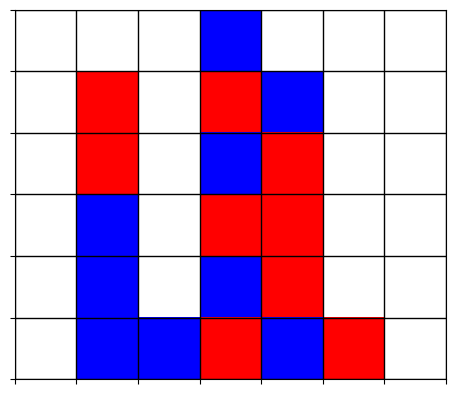

moves=[3, 3, 3, 1, 5, 4, 4, 1, 4, 1, 1, 3, 4, 4, 3, 2, 1, 3]


Input column: 0


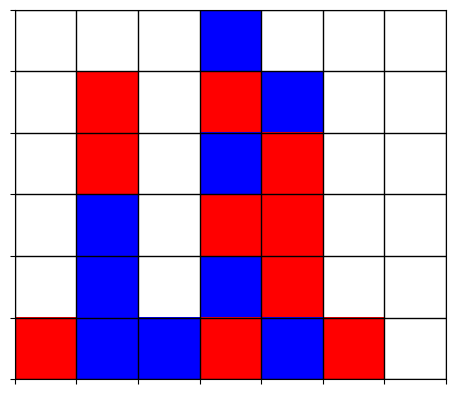

moves=[3, 3, 3, 1, 5, 4, 4, 1, 4, 1, 1, 3, 4, 4, 3, 2, 1, 3, 0]
(array([[0, 0, 0, 2, 0, 0, 0],
       [0, 1, 0, 1, 2, 0, 0],
       [0, 1, 0, 2, 1, 0, 0],
       [0, 2, 0, 1, 1, 0, 0],
       [2, 2, 0, 2, 1, 0, 0],
       [1, 2, 2, 1, 2, 1, 0]], dtype=int32), 1, 19, 0.05263157894736842)
(array([[0, 2, 0, 2, 0, 0, 0],
       [0, 1, 0, 1, 2, 0, 0],
       [0, 1, 0, 2, 1, 0, 0],
       [0, 2, 0, 1, 1, 0, 0],
       [0, 2, 0, 2, 1, 0, 0],
       [1, 2, 2, 1, 2, 1, 0]], dtype=int32), -1, 15, -0.06666666666666667)
(array([[0, 0, 0, 2, 0, 0, 0],
       [0, 1, 0, 1, 2, 0, 0],
       [0, 1, 0, 2, 1, 0, 0],
       [0, 2, 0, 1, 1, 0, 0],
       [0, 2, 2, 2, 1, 0, 0],
       [1, 2, 2, 1, 2, 1, 0]], dtype=int32), 735, 890, 0.8258426966292135)
(array([[0, 0, 0, 2, 2, 0, 0],
       [0, 1, 0, 1, 2, 0, 0],
       [0, 1, 0, 2, 1, 0, 0],
       [0, 2, 0, 1, 1, 0, 0],
       [0, 2, 0, 2, 1, 0, 0],
       [1, 2, 2, 1, 2, 1, 0]], dtype=int32), 11, 37, 0.2972972972972973)
(array([[0, 0, 0, 2, 0, 0, 0],
     

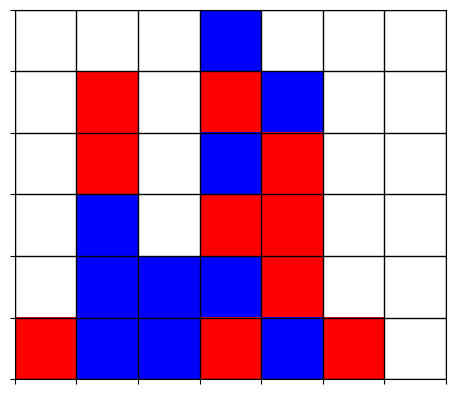

moves=[3, 3, 3, 1, 5, 4, 4, 1, 4, 1, 1, 3, 4, 4, 3, 2, 1, 3, 0, 2]


Input column: 2


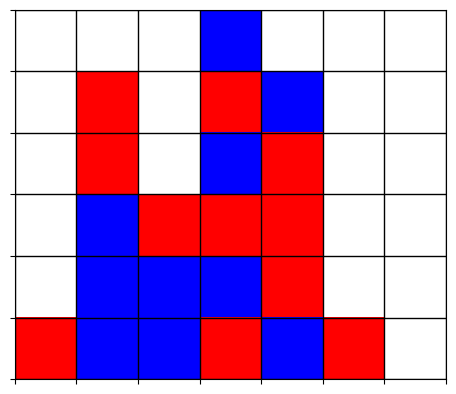

moves=[3, 3, 3, 1, 5, 4, 4, 1, 4, 1, 1, 3, 4, 4, 3, 2, 1, 3, 0, 2, 2]
(array([[0, 0, 0, 2, 0, 0, 0],
       [0, 1, 0, 1, 2, 0, 0],
       [0, 1, 0, 2, 1, 0, 0],
       [0, 2, 1, 1, 1, 0, 0],
       [2, 2, 2, 2, 1, 0, 0],
       [1, 2, 2, 1, 2, 1, 0]], dtype=int32), 967, 967, 1.0)
(array([[0, 2, 0, 2, 0, 0, 0],
       [0, 1, 0, 1, 2, 0, 0],
       [0, 1, 0, 2, 1, 0, 0],
       [0, 2, 1, 1, 1, 0, 0],
       [0, 2, 2, 2, 1, 0, 0],
       [1, 2, 2, 1, 2, 1, 0]], dtype=int32), -3, 5, -0.6)
(array([[0, 0, 0, 2, 0, 0, 0],
       [0, 1, 0, 1, 2, 0, 0],
       [0, 1, 2, 2, 1, 0, 0],
       [0, 2, 1, 1, 1, 0, 0],
       [0, 2, 2, 2, 1, 0, 0],
       [1, 2, 2, 1, 2, 1, 0]], dtype=int32), -1, 11, -0.09090909090909091)
(array([[0, 0, 0, 2, 2, 0, 0],
       [0, 1, 0, 1, 2, 0, 0],
       [0, 1, 0, 2, 1, 0, 0],
       [0, 2, 1, 1, 1, 0, 0],
       [0, 2, 2, 2, 1, 0, 0],
       [1, 2, 2, 1, 2, 1, 0]], dtype=int32), -4, 4, -1.0)
(array([[0, 0, 0, 2, 0, 0, 0],
       [0, 1, 0, 1, 2, 0, 0],
       [0, 1, 

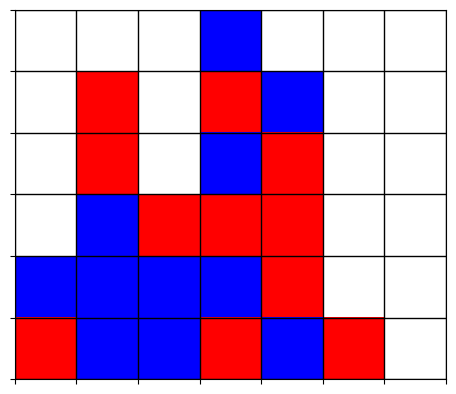

moves=[3, 3, 3, 1, 5, 4, 4, 1, 4, 1, 1, 3, 4, 4, 3, 2, 1, 3, 0, 2, 2, 0]


In [12]:
AIgame()

In [44]:
# I should have written tests for this, but I got a bit lazy about writing tests because I didn't want to have
# to create instances everywhere to test methods, but maybe I should've just done that.

# anyway, empirically it seems to work well -- I played against it a bunch of times and it makes no obviously
# bad moves and wins every time...

In [45]:
# TESTS that i did write:

In [46]:

potential_val_lists(Connect4(), (0, 0))

[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]]

In [3]:
grid = np.array([
    [0, 1, 2, 1, 0],
    [2, 0, 1, 2, 1],
    [1, 2, 0, 1, 2],
    [2, 1, 0, 2, 1],
    [0, 2, 1, 0, 2]
])

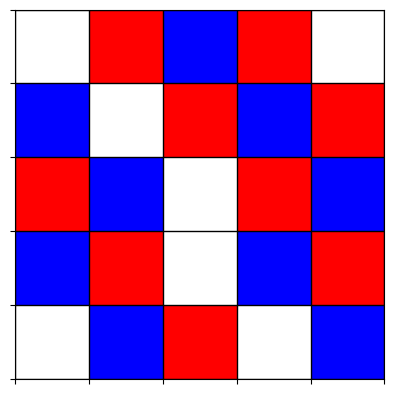

In [47]:
display(grid)

In [48]:
g = Connect4()
g.random_finish()
while not (g.player == None and g.winner == None):
    g = Connect4()
    g.random_finish()
g

Connect4 game:
[[1 2 1 1 2 1 2]
 [1 2 1 2 2 2 1]
 [1 1 2 2 1 2 1]
 [2 1 2 1 1 1 2]
 [2 1 2 2 2 1 2]
 [2 2 1 2 1 1 1]]
Draw

In [49]:
g = Connect4()
g.play(0)
g

Connect4 game:
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]]
player: 2

In [50]:
in_range(7, 6, zip(range(-2, 15), range(-1, 10)))

[(0, 1), (1, 2), (2, 3), (3, 4), (4, 5)]

In [55]:
game = Connect4()
game.play(0)
game.play(1)
game.play(1)
game.play(3)
game.play(3)
game.play(3)
game.play(3)
game.play(2)
game.play(2)
game.play(5)
game.play(2)
print(game)
#game.play(3)

Connect4 game:
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 1 2 0 0 0]
 [0 1 1 1 0 0 0]
 [1 2 2 2 0 2 0]]
winner: 1


In [48]:
def game_of_moves(movelist):
    game = Connect4()
    for move in movelist:
        game = game.play(move)
    return game

In [54]:
m6 = MCTSnode(game_of_moves([3, 4, 3, 3, 4, 3, 3, 2, 2, 4, 4, 0, 2, 3, 2]))
m6.iterate(1000)
m6._print_direct_children()

(array([[0, 0, 0, 2, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 1, 2, 1, 0, 0],
       [0, 0, 1, 2, 2, 0, 0],
       [2, 0, 1, 1, 1, 0, 0],
       [2, 0, 2, 1, 2, 0, 0]], dtype=int32), -45, 63)
(array([[0, 0, 0, 2, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 1, 2, 1, 0, 0],
       [0, 0, 1, 2, 2, 0, 0],
       [0, 0, 1, 1, 1, 0, 0],
       [2, 2, 2, 1, 2, 0, 0]], dtype=int32), -37, 47)
(array([[0, 0, 0, 2, 0, 0, 0],
       [0, 0, 2, 1, 0, 0, 0],
       [0, 0, 1, 2, 1, 0, 0],
       [0, 0, 1, 2, 2, 0, 0],
       [0, 0, 1, 1, 1, 0, 0],
       [2, 0, 2, 1, 2, 0, 0]], dtype=int32), -267, 689)
(array([[0, 0, 0, 2, 0, 0, 0],
       [0, 0, 0, 1, 2, 0, 0],
       [0, 0, 1, 2, 1, 0, 0],
       [0, 0, 1, 2, 2, 0, 0],
       [0, 0, 1, 1, 1, 0, 0],
       [2, 0, 2, 1, 2, 0, 0]], dtype=int32), -43, 59)
(array([[0, 0, 0, 2, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 1, 2, 1, 0, 0],
       [0, 0, 1, 2, 2, 0, 0],
       [0, 0, 1, 1, 1, 0, 0],
       [2, 0, 2, 1, 2, 2, 0